In [3]:
from skimage import io, morphology, filters, segmentation
from skimage.color import rgb2gray, rgba2rgb
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# Image readin
im = rgb2gray(rgba2rgb(io.imread("../images/1carr-96etoh-alexa-sted-decon.tif")))

In [5]:
def biasField(I,mask):
    (rows,cols) = I.shape
    r, c = np.meshgrid(list(range(rows)), list(range(cols)))
    rMsk = r[mask].flatten()
    cMsk = c[mask].flatten()
    VanderMondeMsk = np.array([rMsk*0+1, rMsk, cMsk, rMsk**2, rMsk*cMsk, cMsk**2]).T
    ValsMsk = I[mask].flatten()
    coeff, residuals, rank, singularValues = np.linalg.lstsq(VanderMondeMsk, ValsMsk)
    VanderMonde = np.array([r*0+1, r, c, r**2, r*c, c**2]).T
    J = np.dot(VanderMonde, coeff) # @ operator is a python 3.5 feature!
    J = J.reshape((rows,cols)).T
    return(J)

In [6]:
threshold = filters.threshold_otsu(im)

# Noise reduction by median filtering
dskelm = morphology.disk(1)
imFilt = filters.median(im, dskelm)

In [7]:
clusters = imFilt > threshold
B = biasField(imFilt, clusters)

<ipython-input-5-df088f0a90cb>:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, residuals, rank, singularValues = np.linalg.lstsq(VanderMondeMsk, ValsMsk)


B (mean, min, max): 0.4035896320265947 0.3846228140237776 0.48515141308366927


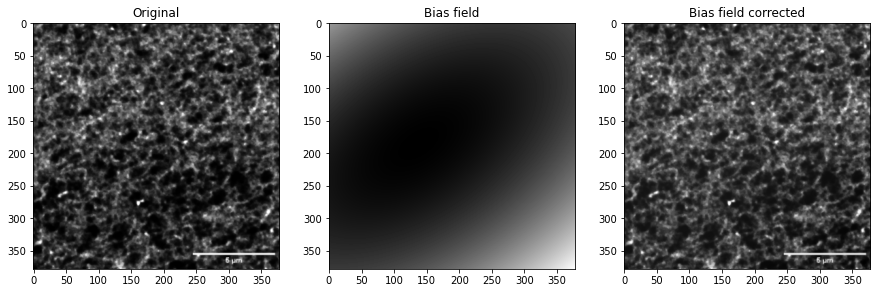

In [8]:
print("B (mean, min, max):", B.mean(), B.min(), B.max())
imBias = imFilt-B+B.mean()
fig, ax = plt.subplots(1, 3, figsize=(15,5)) # figsize sets size in inches
ax[0].imshow(imFilt)
ax[0].set_title('Original')
ax[1].imshow(B)
ax[1].set_title('Bias field')
ax[2].imshow(imBias)
ax[2].set_title('Bias field corrected')
plt.show()

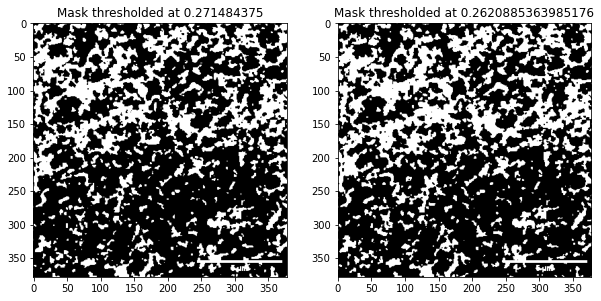

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

proteinsFilt = imFilt > threshold
ax[0].imshow(proteinsFilt)
ax[0].set_title('Mask thresholded at ' + str(threshold))

tProteinsBias = filters.threshold_otsu(imBias)
proteinsBias = imBias > tProteinsBias
ax[1].imshow(proteinsBias)
ax[1].set_title('Mask thresholded at ' + str(tProteinsBias))
plt.show()

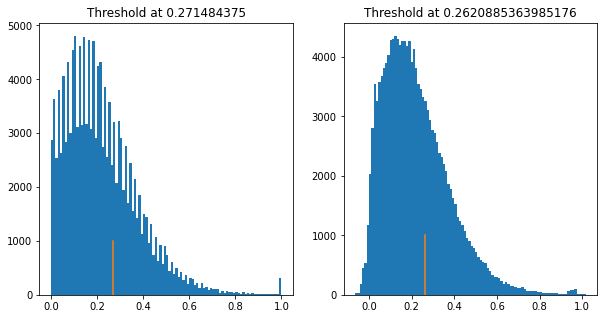

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(imFilt.flatten(),100)
ax[0].plot([threshold,threshold],[0,1000])
ax[0].set_title('Threshold at ' + str(threshold))

ax[1].hist(imBias.flatten(),100)
ax[1].plot([tProteinsBias,tProteinsBias],[0,1000])
ax[1].set_title('Threshold at ' + str(tProteinsBias))
plt.show()